In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import patches

import functions.eddy_feedback as ef
import functions.data_wrangling as data

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

### Import datasets

Here want to compare the same models that have different resolutions. So that is
- HadGEM3-GC31-MM vs HadGEM3-GC31-LL
- OpenIFS-159 vs OpenIFS-511
- We also want to have a look at the PAMIP experiments that simulate El Nino

**NOTE**: Here I am using the non-regridded datasets.

In [2]:
# set paths and use Path class
PATH = '/home/links/ct715/data_storage/PAMIP/processed_monthly'
DIR = Path(PATH)

In [3]:
# Import required datasets into a dictionary
model_list = ['HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'OpenIFS-159', 'OpenIFS-511']
ds = {}
for model in model_list:
    
    # define directory for each model
    file_name = f'{model}_1.1_ubar_epfy_divFy.nc'
    file_dir = DIR / file_name
    
    # import dataset for each model
    dataset = xr.open_mfdataset(
        file_dir,
        parallel=True,
        chunks={'time': 31}
    )
    
    ds[model] = dataset

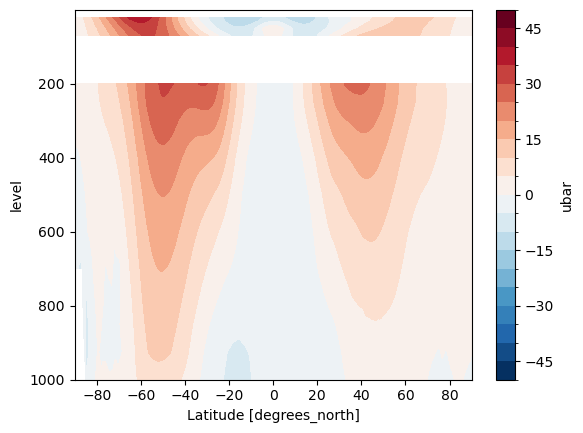

In [18]:
ds['HadGEM3-GC31-MM'].ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False)

### Calculations

- Calculate EFP for later use and also ensure data is correct and matches previous results.
- Calculate seasonal means for winter in both hemispheres

In [15]:
# calculate EFP for each model and save to dictionary
efp_values = {}
for model in model_list:
    
    # calculate EFP
    efp = ef.calculate_efp(ds[model], data_type='pamip')
    
    # save value to dict
    efp_values[model] = efp
    
efp_values

{'HadGEM3-GC31-LL': 0.278,
 'HadGEM3-GC31-MM': 0.3166,
 'OpenIFS-159': 0.3328,
 'OpenIFS-511': 0.2325}

In [6]:
# calculate djf seasonal mean
models_djf = {}
models_jas = {}
for model in model_list:
    
    # calc seasonal mean for each dataset
    djf_mean = data.seasonal_mean(ds[model], season='djf')
    # save to dict
    models_djf[model] = djf_mean
    
    # calc seasonal mean for each dataset
    jas_mean = data.seasonal_mean(ds[model], season='jas')
    # save to dict
    models_jas[model] = jas_mean

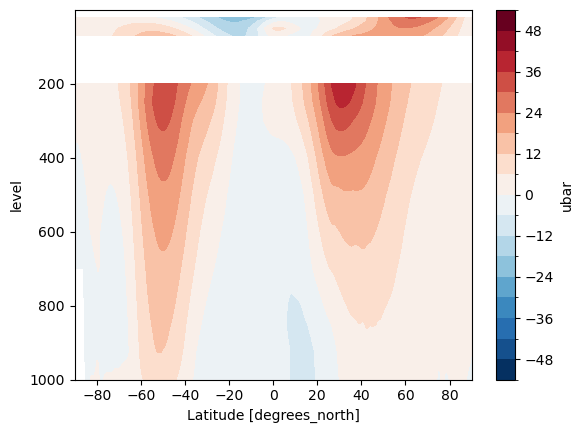

In [7]:
models_djf['HadGEM3-GC31-MM'].ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False)

### Perform data wrangling

- Need to ensure datasets have consistent coordinates, therefore interpolate the larger dataset to match the smaller one.

Currently, the IFS data is not at different resolutions. I am in the process of getting the original data.

In [8]:
models_djf['HadGEM3-GC31-MM'] = models_djf['HadGEM3-GC31-MM'].interp(lat=models_djf['HadGEM3-GC31-LL'].lat.values,
                                                                     level=models_djf['HadGEM3-GC31-LL'].level.values)
models_djf['HadGEM3-GC31-MM']

<xarray.Dataset>
Dimensions:  (time: 1, ens_ax: 300, level: 19, lat: 145)
Coordinates:
  * time     (time) object 2000-12-01 00:00:00
  * lat      (lat) float32 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 20.0 10.0 5.0 1.0
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (time, ens_ax, level, lat) float32 dask.array<chunksize=(1, 300, 19, 145), meta=np.ndarray>
    epfy     (time, ens_ax, level, lat) float32 dask.array<chunksize=(1, 150, 19, 145), meta=np.ndarray>
    divFy    (time, ens_ax, level, lat) float64 dask.array<chunksize=(1, 300, 19, 145), meta=np.ndarray>

In [9]:
# calculate difference for HadGEM models for winter in both hemispheres
hadgem_diff_NH = models_djf['HadGEM3-GC31-LL'].mean(('time', 'ens_ax')) - models_djf['HadGEM3-GC31-MM'].mean(('time', 'ens_ax'))
hadgem_diff_SH = models_jas['HadGEM3-GC31-LL'].mean(('time', 'ens_ax')) - models_jas['HadGEM3-GC31-MM'].mean(('time', 'ens_ax'))

# subset data
hadgem_diff_NH = hadgem_diff_NH.sel(lat=slice(20,85))
hadgem_diff_SH = hadgem_diff_SH.sel(lat=slice(-80,-20))
hadgem_diff_NH = hadgem_diff_NH.sel(level=slice(925., 100))
hadgem_diff_SH = hadgem_diff_SH.sel(level=slice(925., 100))

# # calculate difference for IFS models for winter in both hemispheres
# IFS_diff_NH = models_djf['OpenIFS-159'].mean(('time', 'ens_ax')) - models_djf['OpenIFS-511'].mean(('time', 'ens_ax'))
# IFS_diff_SH = models_jas['OpenIFS-159'].mean(('time', 'ens_ax')) - models_jas['OpenIFS-511'].mean(('time', 'ens_ax'))
# IFS_diff_NH = IFS_diff_NH.sel(lat=slice(0,90))
# IFS_diff_SH = IFS_diff_SH.sel(lat=slice(-90,0))

### Plot differences

I want to have a look at the individual components and compare them between resolutions.

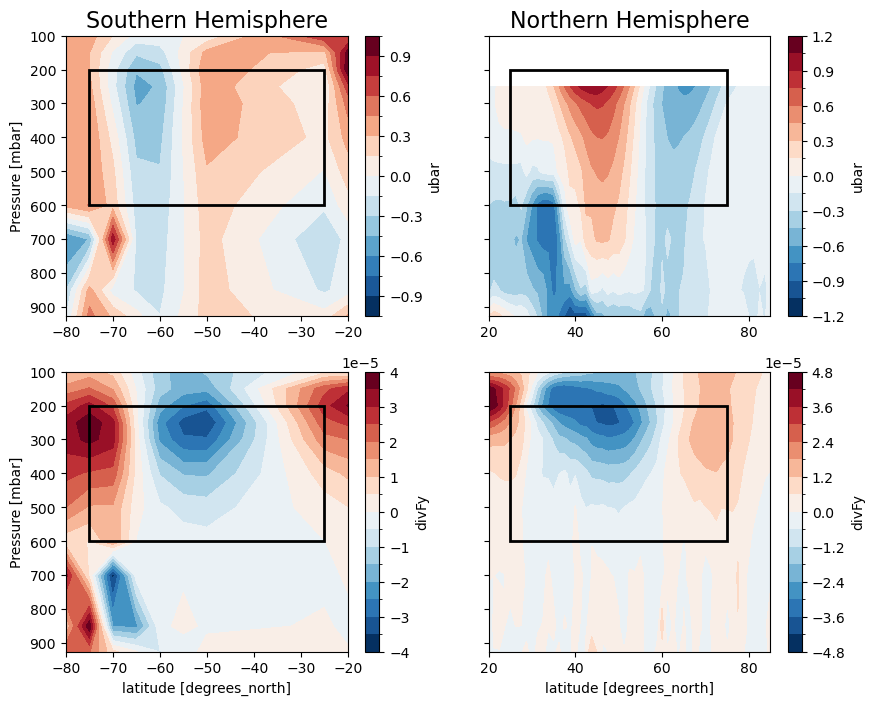

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8), sharey=True)
hadgem_diff_SH.ubar.plot.contourf(levels=20, yincrease=False, ax=axes[0,0])
hadgem_diff_SH.divFy.plot.contourf(levels=20, yincrease=False, ax=axes[1,0])
hadgem_diff_NH.ubar.plot.contourf(levels=20, yincrease=False, ax=axes[0,1])
hadgem_diff_NH.divFy.plot.contourf(levels=20, yincrease=False, ax=axes[1,1])

# set titles
axes[0,0].set_title('Southern Hemisphere', fontsize=16)
axes[1,0].set_title('')
axes[0,1].set_title('Northern Hemisphere', fontsize=16)
axes[1,1].set_title('')

# set axes titles
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')

# plot rectangle
rect_NH = patches.Rectangle((25., 600.), 50, -400, fill=False, linewidth=2)
rect_SH = patches.Rectangle((-75., 600.), 50, -400, fill=False, linewidth=2)
axes[0,0].add_patch(rect_SH)
axes[0,1].add_patch(rect_NH)
axes[1,0].add_patch(patches.Rectangle((-75., 600.), 50, -400, fill=False, linewidth=2))
axes[1,1].add_patch(patches.Rectangle((25., 600.), 50, -400, fill=False, linewidth=2))

plt.show()

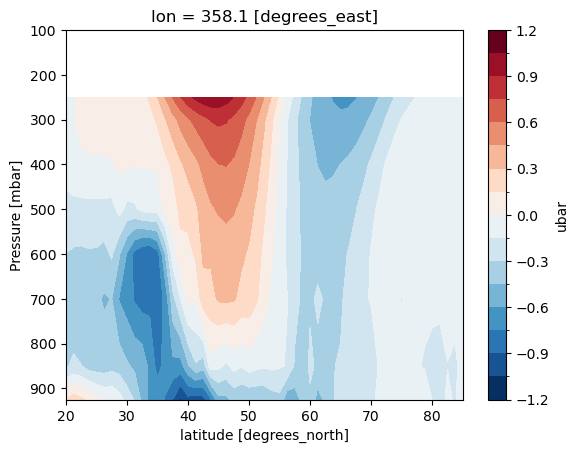

In [11]:
hadgem_diff_NH.ubar.plot.contourf(levels=20, yincrease=False)

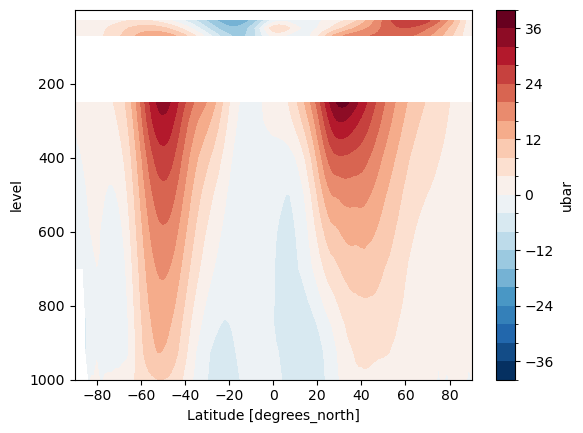

In [12]:
models_djf['HadGEM3-GC31-MM'].ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False)

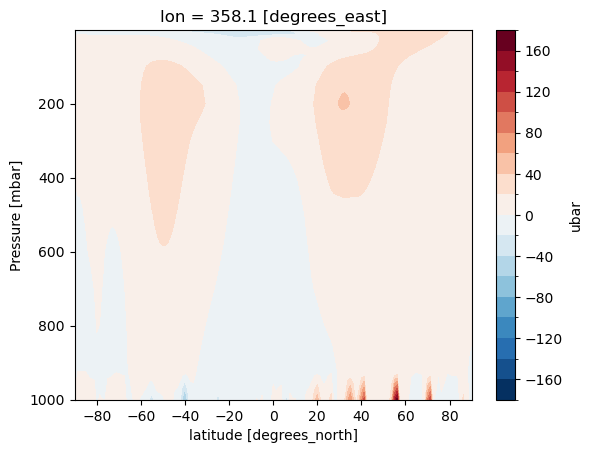

In [13]:
models_djf['HadGEM3-GC31-LL'].ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False)